In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly
from plotly.offline import *
from plotly.subplots import make_subplots
import requests
import json

# Going Forward

## Content

* Introduction

* Customizing graph

* Other graphing options

* Changing queries ... and augmenting data

* What next ... future visualizations?

## Introduction

The majority of the notebooks here utilize the **plotly** module for Python in order to visualize and express data. This notebook will document and demonstrate pointers on extending existing framework for this data visualization.

For the most part, two subsets of **plotly** tools are used: **plotly express** and **graph objects**. Difference being that **plotly express** is a higher level tool that has more built-in features, more suited towards less complicated visualizations.


## Customizing Graph

Each graph figure contains a layout that can edit how data is expressed. Updating the layout of the graph can take many forms - see below example using a slightly modified version of the "Comparison of Pass Rates Between Consecutive Builds" figure in the **Platform Certification Heatmap** notebook. 

In [2]:
def run_query(query, host="172.23.99.54", port=8093, username="Administrator", password="password", param=None):
    url_base = f"http://{host}:{port}/query/service"
    params = {'statement': query, 'scan_consistency': 'REQUEST_PLUS'}
    if param:
        params.update(param)
    response = requests.get(url=url_base, params=params, auth = requests.auth.HTTPBasicAuth(username, password))
    return response.json()

query_last_weekly_build = f'SELECT raw `build` FROM server WHERE `build` <= $version AND `build` > "7.0.0" GROUP BY `build` HAVING sum(totalCount) > 10000 ORDER BY `build` DESC LIMIT 3'
query_pct = 'SELECT a.`build` as `build`, ROUND((SUM(CASE WHEN a.platform = "rhel8" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "rhel8" THEN a.failCount END))/SUM(CASE WHEN a.platform = "rhel8" THEN a.totalCount END)*100,0) AS `rhel8`, ROUND((SUM(CASE WHEN a.platform = "centosnonroot" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "centosnonroot" THEN a.failCount END))/SUM(CASE WHEN a.platform = "centosnonroot" THEN a.totalCount END)*100,0) AS `centosnonroot`, ROUND((SUM(CASE WHEN a.platform = "debian10" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "debian10" THEN a.failCount END))/SUM(CASE WHEN a.platform = "debian10" THEN a.totalCount END)*100,0) AS `debian10`, ROUND((SUM(CASE WHEN a.platform = "ubuntu20" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "ubuntu20" THEN a.failCount END))/SUM(CASE WHEN a.platform = "ubuntu20" THEN a.totalCount END)*100,0) AS `ubuntu20`, ROUND((SUM(CASE WHEN a.platform = "suse15" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "suse15" THEN a.failCount END))/SUM(CASE WHEN a.platform = "suse15" THEN a.totalCount END)*100,0) AS `suse15`, ROUND((SUM(CASE WHEN a.platform = "oel8" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "oel8" THEN a.failCount END))/SUM(CASE WHEN a.platform = "oel8" THEN a.totalCount END)*100,0) AS `oel8`, ROUND((SUM(CASE WHEN a.platform = "windows" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "windows" THEN a.failCount END))/SUM(CASE WHEN a.platform = "windows" THEN a.totalCount END)*100,0) AS `windows`, ROUND((SUM(CASE WHEN a.platform = "ipv6" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "ipv6" THEN a.failCount END))/SUM(CASE WHEN a.platform = "ipv6" THEN a.totalCount END)*100,0) AS `ipv6`, ROUND((SUM(CASE WHEN a.platform = "centos" THEN a.totalCount END)-SUM(CASE WHEN a.platform = "centos" THEN a.failCount END))/SUM(CASE WHEN a.platform = "centos" THEN a.totalCount END)*100,0) AS `ce` FROM ( SELECT `build`, name, totalCount, failCount, CASE WHEN name LIKE "centos-ipv6%" THEN "ipv6" ELSE SPLIT(name,"-")[0] END AS platform FROM server WHERE `build` in $version AND (name LIKE "%os_certify%" OR (name LIKE "centos-ipv6%" AND name NOT LIKE "centos-ipv6_sanity%"))) AS a GROUP BY `build` ORDER BY `build` ASC'
result1 = run_query(query=query_last_weekly_build, param={'$version': f'"7.0.0-5295"'})
weekly_builds = result1['results']
result1 = run_query(query=query_pct, param={'$version': json.dumps(weekly_builds)})

color_var = 255
barGraph = []
for entry in result1['results']:
    build = entry.pop('build')
    entry = pd.json_normalize(entry)
    bar = f"go.Bar(name=str(build), x=entry.columns, y=entry.iloc[0], marker_color='rgb({color_var/3},{color_var/2},{color_var})')"
    barGraph.append(eval(bar))
    color_var = color_var * (1 - 0.6/3)

Starting with this:

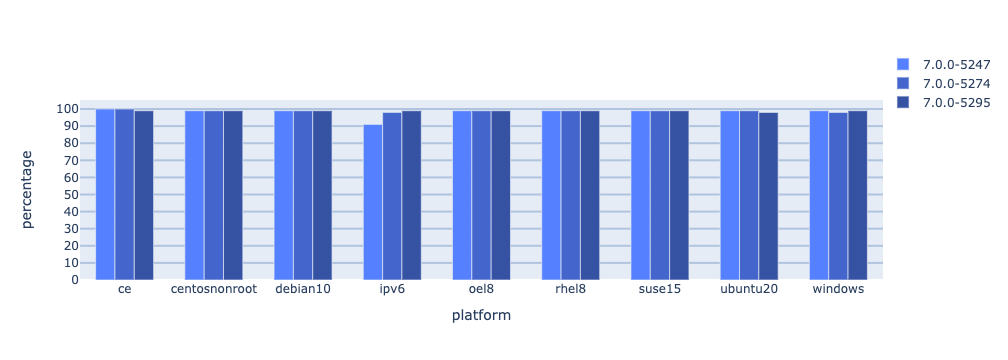

In [5]:
groupedBarGraph = go.Figure(data=barGraph)

groupedBarGraph.update_layout(
    barmode='group',
    bargap=.35,
    legend=dict(y=1.28, x=1),
    height=300
)
groupedBarGraph.update_xaxes(title=dict(text="platform"))
groupedBarGraph.update_yaxes(title=dict(text="percentage"), tickvals=[0,10,20,30,40,50,60,70,80,90,100], gridcolor="lightsteelblue", gridwidth=2)

groupedBarGraph.show()

The figure here is called **groupedBarGraph**. Using groupedBarGraph.update_layout(), we can change the styling of the graph: For instance, changing the **height** will change the height of the overall graph, changing the **bargap** will modify the space between each group of bars. The dictionary that the **legend** is set to specifies the position of the legend, where the bottom left of the graph is (0, 0) and the top right of the graph is (1, 1).

```
groupedBarGraph.update_layout(
    barmode='group',
    bargap=.1,
    legend=dict(y=0, x=1),
    height=500
)

groupedBarGraph.show()
```

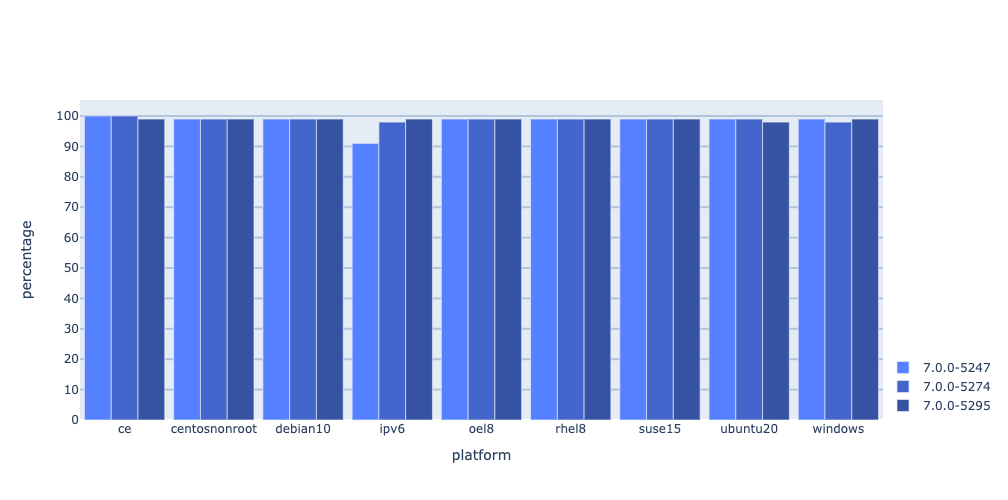

In [6]:
groupedBarGraph.update_layout(
    barmode='group',
    bargap=.1,
    legend=dict(y=0, x=1),
    height=500
)

groupedBarGraph.show()

Other options include modifying the legend, axes labels, or bar group names. For more information, [see the documentation](https://plotly.com/python/creating-and-updating-figures/).

## Other Graphing Options

There are various alternative modules that are available to express data aside from plotly.

Notably, the **seaborn** module is used to create the heatmap on the **Platform Certification Notebook**. **Seaborn** also presents other options besides those of heatmaps - [see the documentation](https://seaborn.pydata.org/examples/index.html). Seaborn runs on [matplotlib](https://matplotlib.org/stable/tutorials/index.html).

Also see a [demo of **Perspective**](https://bl.ocks.org/texodus/efd4a857aca9a52ab6cddbb6e1f701c9).

## Changing Queries

Queries wil be written in Couchbase's query language N1Ql. 

In these notebooks, most queries will be identifiable either by a long string or a variable with the word **query** in it. Some are pieced together while the notebook runs. Minor adjustments to the data of each figure may be simpler to accomplish through modifications of each figure's respecive query(s) rather than, say, manual modification through Pytho. Below is a very brief example using the query from the **DurationAnalysis** notebook, slightly modified for simplicity's sake, of editing one of this notebook's queries.

```
duration_query = f'SELECT component, url || to_string(build_id) as `url`, name, round(duration/1000/60) AS minutes, os, failCount as fail_count, {search_area} as area FROM server WHERE LOWER(os)="{parameters["os"]}" AND LOWER(component)="durability" AND `build`="{release}-{current_build}" LIMIT 800;'
```

This query should return one build's testing duration data (component, link, name of test, minutes, os, and failures) of a maximum of 800 tests under the given os, where the component is durability.

Say, however, that we want to filter down further, only showing tests under the area of **transaction** in addition the previous filters. Additionally, say we want to show by hours instead and lower the maximum number of result entries to 10.


To accomplish this, instead of dividing the **duration** by both 1000 and 60 to receive the number of minutes, we can remove the divided by 60 part to change the units to be equal to an hour. We can add an additional qualifier reading **LOWER(area)="transaction" AND** to filter to only results where the area is transaction. Finally, we can change the **LIMIT** to 10 rather than 800. 

```
duration_query = f'SELECT component, url || to_string(build_id) as `url`, name, round(duration/1000) AS minutes, os, failCount as fail_count, {search_area} as area FROM server WHERE LOWER(os)="{parameters["os"]}" AND LOWER(component)="durability" AND LOWER(area)="transaction" AND `build`="{release}-{current_build}" LIMIT 10;'
```

It is noteworthy, however, that occasionally, an option is already given that users can easily change without even having to edit a query. It is advised to read the markdown cells for each figure to see if there are any such options for each figure. 


[See the Couchbase N1QL tutorial](https://query-tutorial.couchbase.com/tutorial/#1) if need be for more information.

## What's Next and Future Visualizations

Towards the future, one primary focus would be to move away from locking onto just analyzing the pass rate of each test, as many of these notebooks do. Perhaps this includes not only looking at other factors, but also expanding the scope of these visualizations.


In the long term, it is well worth it to consider how we can use visualizations, whether already made or potential ones in the future, for analysis and possibly provide insight on more than just how different tests are currently performing in pass rates: perhaps going towards what can fix these failures. Furthermore, it may be possible to look at how resource usage such as for VMs can be optimized. For instance, the **DurationAnalysis** notebook is one small step and example of branching out beyond just looking at and comparing pass rates across different filters and time frames. Adding additional data may reveal interesting patterns or useful information about these tests and their qualities, and beyond just test duration and things of such level, there may be other factors involved that aren't obvious at first.

Current notebooks primarily hone in on data from the past in present, which leaves the future as an untapped area. Certainly, it substantiably more difficult to predict the future based on previous data than to simply visualize and process already existing data: the two are vastly different. Predicting the results and trends of the future can entail a lot: careful observation of previous data, thorough examination of patterns of that data, and meticulous investigation of what things influence tests so that some patterns may occur, or why might there be no evident pattern at all. After all, the lack of something may be just as telling as its presence. Whatever this may require in the end, though, there are tools available. In terms of looking to the past, these notebooks and whatever may come out of their improvements may come of assistance. Perhaps artificial intelligence and machine learning could be used to complete the demanding work of projecting the future through predictive modeling and analytics.